<center>
    <img width='80%' src='rapids_workflow.png'></center>    


<h1>RAPIDS Demo - End-To-End ML Workflow - Dask Early Draft </h1>

In [1]:
import pandas as pd, numpy as np, sklearn
from sklearn import datasets
import cudf, numba, scipy
from numba import cuda 
import time

In [2]:
import dask, dask.array, dask.dataframe
from dask import delayed
import dask_cudf

In [3]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

# 1. Create Dask Cluster

In [6]:
cluster = LocalCUDACluster(ip="")
client = Client(cluster)

In [7]:
client

Client Scheduler: tcp://172.17.0.2:35051 Dashboard: http://172.17.0.2:8787/status,Cluster Workers: 4 Cores: 4 Memory: 270.40 GB


-----
# 2. Generate Dataset [ X: features, y: labels ]

Set the size of the generated dataset -- the number of total samples is determined by this value

In [8]:
nTotalSamples = 100000000

Next we'll use <a href='https://scikit-learn.org/stable/datasets/index.html#generated-datasets'>sklearn.datasets</a> to build synthetic sub-datasets of the size we specified above. We'll build three sub-datasets and combine them together and then use a trained model to see if we can determine which of sub-dataset a sample belongs to. The three sub-datasets are built using the moons, blobs, and swiss-roll generators. These sub-datasets were selected for their distinct visual features.

# 2.1 Define Sharded Data Gen

In [9]:
nDatasets = 3
nDatasetCols = 4

nShards = 4
nSamplesPerShardSubset = (nTotalSamples//nShards)//nDatasets
nSamplesPerShard = nSamplesPerShardSubset*nDatasets

In [10]:
nSamplesPerShard, nSamplesPerShardSubset

(24999999, 8333333)

In [11]:
def generate_data_shard ( nSamplesPerShardSubset ):
    
    # generate features
    swissRollDataset = datasets.make_swiss_roll( n_samples = nSamplesPerShardSubset, noise = .005)[0]

    moonsDataset = datasets.make_moons(n_samples = nSamplesPerShardSubset, noise = 0)[0]
    moonsDataset = np.hstack( [moonsDataset, np.zeros( (moonsDataset.shape[0], 1) )] )*5

    blobsDataset = datasets.make_blobs( n_samples = nSamplesPerShardSubset, centers = 5,  n_features = 3, 
                                        cluster_std = 0.25,  random_state = 0)[0] + [0, 1.5, 0]
    
    # generate labels for classification 
    blobsLabels = np.zeros(blobsDataset.shape[0])
    moonsLabels = 1 * np.ones(moonsDataset.shape[0])
    sRollLabels = 2 * np.ones(swissRollDataset.shape[0])

    features = np.vstack([blobsDataset, moonsDataset, swissRollDataset])
    labels = np.hstack( [blobsLabels, moonsLabels, sRollLabels] )
    
    return np.asfortranarray(np.hstack( [ features, np.expand_dims(labels,axis=1) ] ))

# 2.2 Define Transformation [ Standard Scaler ]
Transforming a dataset is a common requirement prior to training upstream models. For each feature in the dataset we remove the mean and divide by the standard deviation -- this makes each feature behave like a normally distributed variable (e.g. gaussian with 0 mean and unit variance). 

For the data on the CPU we can use the pre-built <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html'>sklearn.preprocessing.StandardScaler</a> function.
In the case of the GPU, we demonstrate how the same transformation can be built using a custom (user defined) function written as a <a href='http://numba.pydata.org/numba-doc/0.13/CUDAJit.html'>just-in-time numba kernel</a>. 

Note that we compute the mean and standard deviation statistics on the training data, and then apply the transformation to the training and test data (i.e., the test data is never seen when computing the mean & standard deviation).

In [12]:
@cuda.jit 
def gpu_scale(outputCol, colGPUArrays, colMeans, colStDevs, labelCol):
    iRow = cuda.grid(1)
    if iRow < colGPUArrays.size:
        if not labelCol:
            outputCol[iRow] = ( colGPUArrays[iRow] - colMeans ) / ( colStDevs + 1e-10 )
        else:
            outputCol[iRow] = colGPUArrays[iRow]

In [13]:
def standard_scaler_numba( targetDF, trainMeans = None, trainStdevs = None):
    nRows = targetDF.shape[0]
    
    blockSize = 128
    blockCount = nRows // blockSize + 1
    scaledDF = cudf.DataFrame()
    
    if trainMeans is None and trainStdevs is None:
        trainMeans = {}
        trainStdevs = {}
        
    for iColName in targetDF.columns:
        colGPUArray = targetDF[iColName].to_gpu_array()
        outputCol = cuda.device_array ( shape=(nRows), dtype=colGPUArray.dtype.name)       
        if iColName not in trainMeans.keys():
            trainMeans[iColName] = targetDF[iColName].mean()
        if iColName not in trainStdevs.keys():
            trainStdevs[iColName] = targetDF[iColName].std()
        labelCol = (iColName == targetDF.columns[-1])
        gpu_scale[(blockCount),(blockSize)](outputCol, colGPUArray, trainMeans[iColName], trainStdevs[iColName], labelCol)
        scaledDF.add_column(name=iColName, data = outputCol)    

        
    return scaledDF, trainMeans, trainStdevs

# 2.3 Define and Visualize Dask Compute Graph

In [14]:
delayedDataShards = [ delayed(generate_data_shard)(nSamplesPerShardSubset) for iShard in range(nShards) ]
delayedDataFrames = [ delayed(pd.DataFrame)(iShard) for iShard in delayedDataShards ]
delayedGPUDataFrames = [ delayed(cudf.from_pandas)(iShard) for iShard in delayedDataFrames]
mergedGPUDataFame = delayed(cudf.concat)(delayedGPUDataFrames)
result = delayed( standard_scaler_numba)( mergedGPUDataFame )

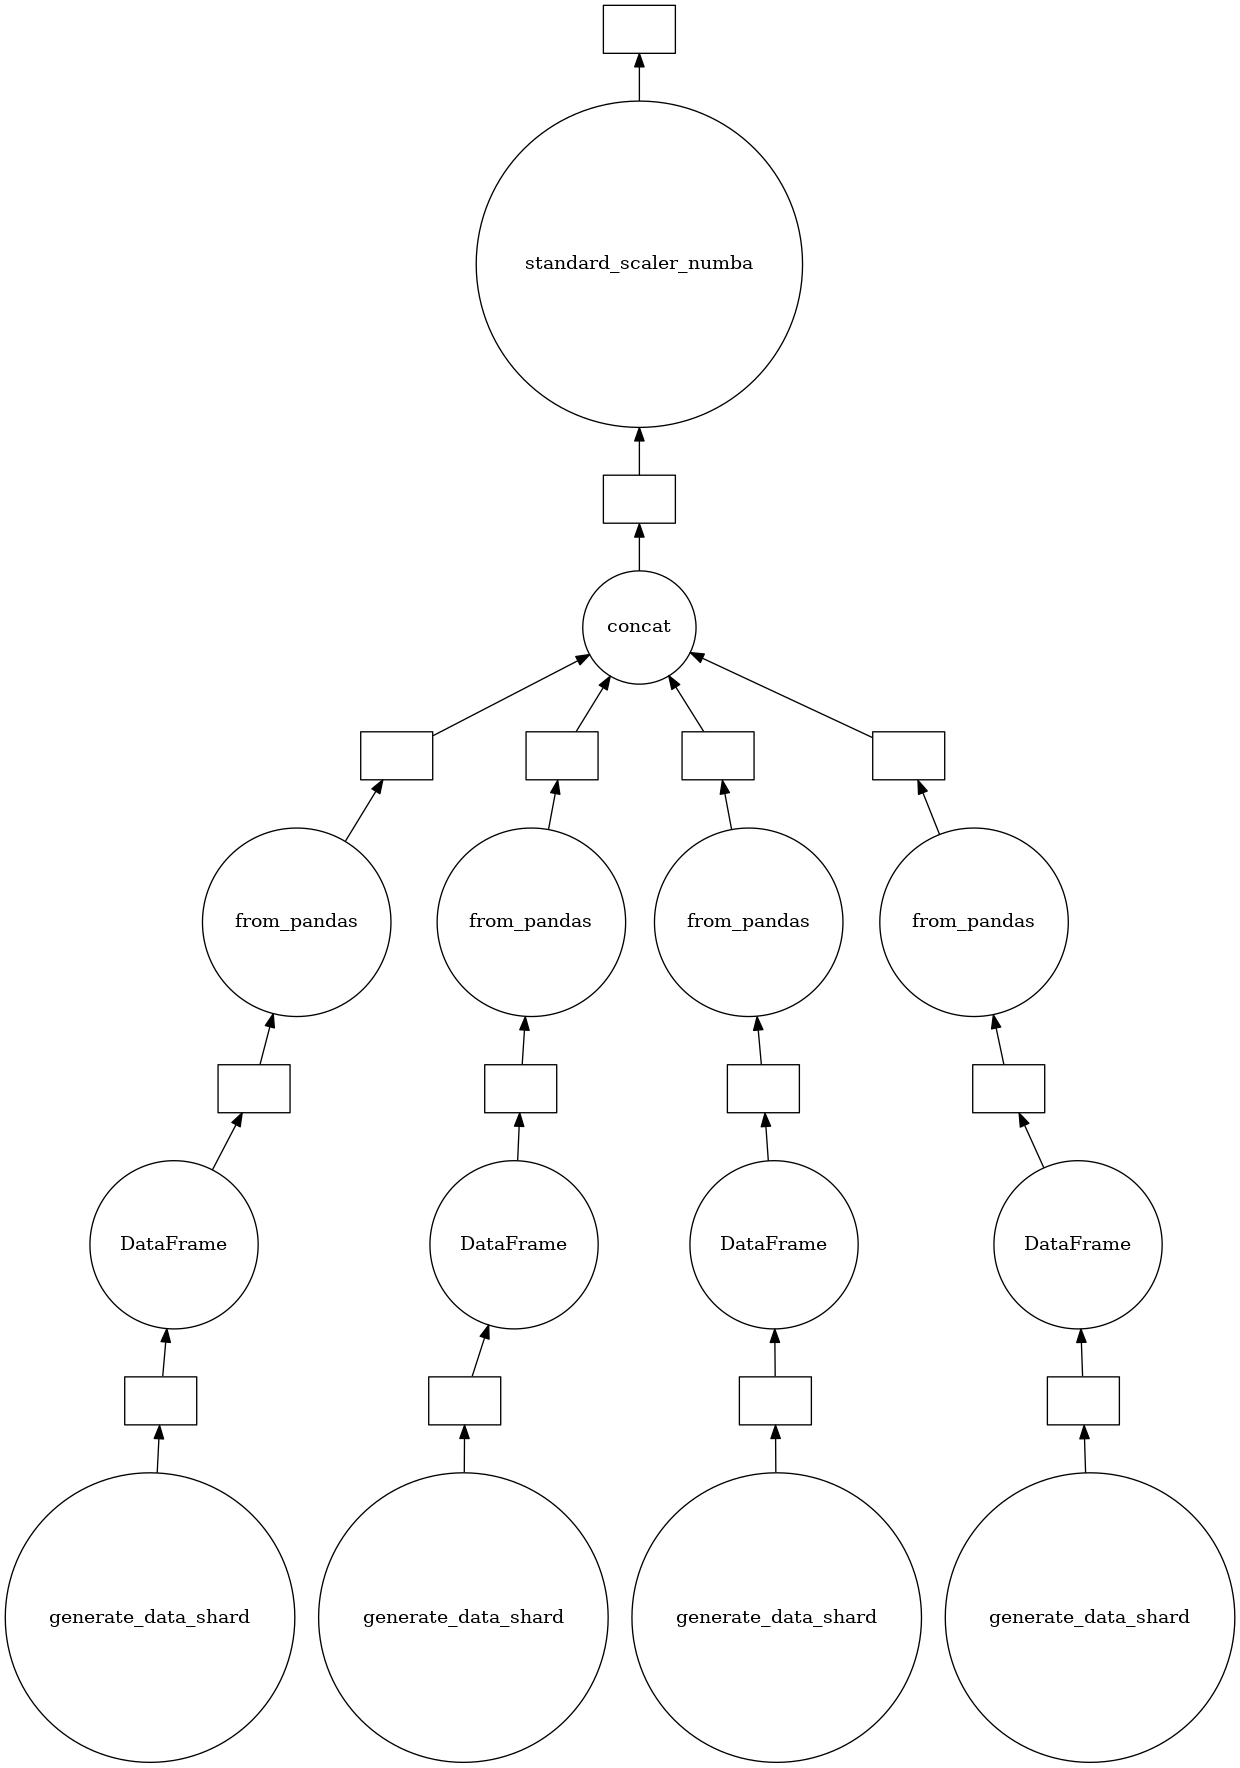

In [15]:
result.visualize()

# 2.4 Compute/Execute Task Graph

In [16]:
tic = time.time()
cudf_X_train, trainMeans, trainStdevs = result.compute()
print( time.time() - tic )

30.911237478256226


In [ ]:
cudf_X_train.head(15).to_pandas()

# 2.5 Visualize Data [ after re-scaling ]
we are visualizing just a small batch of the first shard's data
> plotting requires a copy to CPU memory 

In [ ]:
import ipyvolume as ipv

In [ ]:
def ipv_plot_data( data, colorStack = 'purple', 
                  maxSamplesToPlot = 100000, 
                  holdOnFlag = False, markerSize=.5):
    
    nSamplesToPlot = np.min( ( len(data), maxSamplesToPlot ) )
    if not holdOnFlag: ipv.figure(width=600,height=600)
        
    if isinstance(colorStack, np.ndarray):
        colorStack = colorStack[0:maxSamplesToPlot,:]

    ipv.scatter( data[0:nSamplesToPlot,0], 
                 data[0:nSamplesToPlot,1], 
                 data[0:nSamplesToPlot,2], size = markerSize, 
                 marker = 'sphere', color = colorStack)
    
    if not holdOnFlag: ipv.show()


In [ ]:
ipv_plot_data(cudf_X_train.head(1000).to_pandas().values)

In [ ]:
ipv.figure()
ipv_plot_data(cudf_X_train.loc[0:10000,cudf_X_train.columns[:-1]].to_pandas().values, 'gold', 10000, True)
ipv_plot_data(cudf_X_train.loc[nSamplesPerShardSubset:nSamplesPerShardSubset+10000,cudf_X_train.columns[:-1]].to_pandas().values, 'green', 10000, True)
ipv_plot_data(cudf_X_train.loc[2*nSamplesPerShardSubset:2*nSamplesPerShardSubset+10000,cudf_X_train.columns[:-1]].to_pandas().values, 'purple', 10000, True)
ipv.show()

# 3. Non-Dask [ generate + transform ]

In [5]:
%%time
nSamplesPerSubDataset = nTotalSamples//3

swissRollDataset = datasets.make_swiss_roll( n_samples = nSamplesPerSubDataset, noise = .005)[0]

moonsDataset = datasets.make_moons(n_samples = nSamplesPerSubDataset, noise = 0)[0]
moonsDataset = np.hstack( [moonsDataset, np.zeros( (moonsDataset.shape[0], 1) )] )*5

blobsDataset = datasets.make_blobs( n_samples = nSamplesPerSubDataset, centers = 5,  n_features = 3, 
                                    cluster_std = 0.25,  random_state = 0)[0] + [0, 1.5, 0]

X = np.vstack([blobsDataset, moonsDataset, swissRollDataset])

# generate labels for classification 
blobsLabels = np.zeros(blobsDataset.shape[0])
moonsLabels = 1 * np.ones(moonsDataset.shape[0])
sRollLabels = 2 * np.ones(swissRollDataset.shape[0])

y = np.expand_dims(np.hstack( [blobsLabels, moonsLabels, sRollLabels] ), axis=1)

dataset = np.hstack([X,y])

pandasDataset = pd.DataFrame(dataset)


scaler = sklearn.preprocessing.StandardScaler().fit(pandasDataset) # normalize
pandasDataset = scaler.transform(pandasDataset)


CPU times: user 1min 51s, sys: 20.3 s, total: 2min 11s
Wall time: 48.6 s


-----
# 4. - Model Building with XGBoost
-----
XGBoost is a popular algorithm for classification. It uses a sequence of decision trees built in succession such that each new tree attempts to correct the errors made by its predecessors (analogy to multiple golf swings [ each improving on the past ] to reach a target). For a deeper dive into how XGBoost works check out the following dev blog: <br>
> https://devblogs.nvidia.com/gradient-boosting-decision-trees-xgboost-cuda/

<img src='xgboost.png' width =90%>
<center> img src: https://explained.ai/gradient-boosting/L2-loss.html </center>

## Prepare Data for Training

In [ ]:
X = pd_X_train
y = pd_y_train

In [ ]:
X_gpu = xgboost.DMatrix(pd_X_train, label=np.squeeze(pd_y_train))
y_gpu = xgboost.DMatrix(pd_X_test, label=np.squeeze(pd_y_test))

## Specify Model Parameters

noteable parameters: [ to see all available options execute '?xgboost.XGBClassifier' in a new cell] 

* __max_depth__ : int [ default = 3 ] -- Maximum tree depth for base learners.
* __n_estimators__ : int [ default = 100 ] -- Number of boosted trees to fit.
* __n_jobs__ : int [ default = 1 ] -- Number of parallel threads used to run xgboost.

In [ ]:
cpuMaxDepth = 3 # default
nTrees = 100 # default

gpuMaxDepth = 10

nCores = !nproc --all
nCores = int(nCores[0])

paramsGPU = {
    'max_depth': gpuMaxDepth,
    'n_estimators': nTrees,
    'n_gpus': 1,
    'tree_method': 'gpu_hist',
    'objective': 'gpu:reg:linear', 
    'random_state': 0,
    'verbose_model': True
}
paramsCPU = {
    'max_depth': cpuMaxDepth,
    'n_estimators': nTrees,
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'n_jobs': nCores
}

-----
# 4.1 - Model Training

## Train on **CPU**

In [ ]:
xgBoostModelCPU = xgboost.XGBClassifier(max_depth = paramsCPU['max_depth'], 
                                        n_estimators = paramsCPU['n_estimators'],
                                        tree_method = paramsCPU['tree_method'],
                                        objective = paramsCPU['objective'],                                        
                                        n_jobs = paramsCPU['n_jobs'])

In [ ]:
xgBoostModelCPU, print("using {} CPU cores for parallel xgboost training".format(nCores))

In [ ]:
%%time
startTime = time.time()

xgBoostModelCPU.fit( X, np.squeeze(y) );

cpuXGBoostTime = time.time() - startTime

## Train on **GPU**

In [ ]:
%%time
startTime = time.time()

xgBoostModelGPU = xgboost.train( dtrain = X_gpu, params = paramsGPU)

gpuXGBoostTime = time.time() - startTime

## Evaluate Training Speedup

In [ ]:
cpuXGBoostTime/gpuXGBoostTime

-----
# 4.2 - Model Inference

## Infer/predict using Trained **CPU** Model

In [ ]:
%%time
startTime = time.time()

yPredTrain = xgBoostModelCPU.predict(pd_X_train)
yPredTest = xgBoostModelCPU.predict(pd_X_test)

cpuXGBoostInferenceTime = time.time() - startTime

## Infer/predict using Trained **GPU** Model
> note that our objective was changed to a regression [ gpu accelerated ] so we must take care to convert each of our predictions from a continuous value to a discrete class (essentially by rounding).

In [ ]:
# convert continuous prediction to a multi-class option
def continuous_to_discrete( data, nClasses = 3):
    data[data>nClasses-1] = nClasses-1 # filter values beyond the possible classes
    return np.abs(np.round(data))

In [ ]:
%%time
startTime = time.time()

yPredTrain_GPU = continuous_to_discrete ( xgBoostModelGPU.predict(X_gpu) )
yPredTest_GPU = continuous_to_discrete ( xgBoostModelGPU.predict(y_gpu) )

gpuXGBoostInferenceTime = time.time() - startTime

## Evaluate Inference Speedup

In [ ]:
cpuXGBoostInferenceTime/gpuXGBoostInferenceTime

-----
# 4.3 - Evaluate Accuracy

In [ ]:
print( 'CPU test accuracy: {0:.6f} '.format( accuracy_score(pd_y_test, yPredTest) ))
print( 'GPU test accuracy: {0:.6f} '.format( accuracy_score(pd_y_test, yPredTest_GPU) ))

TODO: to increase model accuracy, increase complexity, number of trees, max_depth


In [ ]:
print('\n confusion matrix on TRAIN data -- ')
print(confusion_matrix(pd_y_train, yPredTrain))
print('\n confusion matrix on TEST data -- ')
print( confusion_matrix(pd_y_test, yPredTest))

In [ ]:
print('\n confusion matrix on TRAIN data -- ')
print(confusion_matrix(pd_y_train, yPredTrain_GPU))
print('\n confusion matrix on TEST data -- ')
print( confusion_matrix(pd_y_test, yPredTest_GPU))

# 4.4 - Visualize Model Outputs

## Visualizing a CPU boosted tree

In [ ]:
fig = plt.figure(figsize=(50,50))
plot_tree(xgBoostModelCPU, num_trees=0, ax=plt.subplot(1,1,1))

## Visualizing a GPU Boosted Tree

In [ ]:
fig = plt.figure(figsize=(50,50))
plot_tree(xgBoostModelGPU, num_trees=0, ax=plt.subplot(1,1,1))

## Visualize Class Predictions

In [ ]:
def map_colors_to_clusters_topK ( dataset, labels, topK=None, cmapName = 'tab10'):
    if topK == None:
        topK = dataset.shape[0]
    
    colorStack = np.zeros((topK, 3), dtype=np.float32)
    
    cMap = plt.get_cmap(cmapName)
    for iColor in range ( topK ):
        colorStack[iColor] = cMap.colors[ labels[iColor] ]
        
    return colorStack    

In [ ]:
colorStackClassifier = map_colors_to_clusters_topK ( pd_X_test, yPredTest_GPU.astype(np.int), topK=None )

In [ ]:
ipv_plot_data( pd_X_test, colorStack= colorStackClassifier)

-------
# Extensions
-------

# Ext.1 : Growing the Model Ensemble ( DBScan Clustering )

<img width='95%' src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png'>

## DBScan via sklearn [ CPU ]

In [ ]:
# sub-sample
nSamplesToCluster = 30000
pd_X_test_sampled = pd_X_test[:nSamplesToCluster, :]  
cudf_X_test_sampled = cudf_X_test.loc[0:nSamplesToCluster,list(cudf_X_test.columns)]

In [ ]:
%%time
startTime = time.time()

dbScanModel = DBSCAN( min_samples = 10, n_jobs = nCores ).fit(pd_X_test_sampled)
labels = dbScanModel.labels_

sklearnDBScanTime = time.time() - startTime

## DBScan via cuml [ GPU ]

In [ ]:
%%time
startTime = time.time()

clustering_cuml = cuml.DBSCAN( eps = .15 , min_samples = 200 )
clustering_cuml.fit( cudf_X_test_sampled )

rapidsDBScanTime = time.time() - startTime

In [ ]:
%%time
print( clustering_cuml.labels_.value_counts() )

## Evaluate Clustering Speedup

In [ ]:
sklearnDBScanTime/rapidsDBScanTime

## Map Clusters to Colors and Visualize

In [ ]:
%%time
colorStack = map_colors_to_clusters_topK( pd_X_test, clustering_cuml.labels_, nSamplesToCluster  )

In [ ]:
def colored_topK ( dataset, topK = None):    
    if topK == None:
        topK == dataset.shape[0]
        
    return lambda dataset, colorStack, topK : ipv.quickscatter( dataset[0:topK, 0], 
                                                                dataset[0:topK, 1], 
                                                                dataset[0:topK, 2], 
                                                                size = .5, marker = 'sphere', 
                                                                color = colorStack)  

In [ ]:
colored_topK( pd_X_test_sampled, nSamplesToCluster )(pd_X_test_sampled, colorStack, nSamplesToCluster)

### [ TODO ] Ext.2 : cross-validation
### [ TODO ] Ext.3 : hyper-parameter search

-----
# End [ thanks! ]

please provide feedback/suggestions and errata @ https://github.com/miroenev/rapids